In [2]:
from growth import model, integrate, viz
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

consts=model.load_constants()

## Exploration of Phage infection dynamics with the Flux Parity model (FPM)

### Rationale
Previous studies of bacteriophage infections have been focused on phage biology and phage infection steps/mechanisms. Here, we apply the "flux parity" protein allocation model to a bacteriophage-infected *E. coli* cell to assess the dynamics of viral proteome accumulation inside the bacteria.

### Assumptions
For the plots in this notebook, we assumed the following:
- Initial biomass is set to $10^9$ amino acids, roughly the biomass of a single *E. coli* cell at birth.
- Initial conditions are steady-state growth in rich nutrient conditions ($\nu_{max} = 20$).
- At $t=0$, $\phi_{phage}$ is instantly "turned on". $\phi_{phage}$ represents the fraction of the proteome allocation towards viral protein expression.
- The mass of one phage is assumed to be $\approx 30*10^6$ Daltons, which is also the molecular mass of the phage genome.
- Phage assembly is assumed to be growth-limited, thus making viral protein translation dynamics the relevant dynamic for phage infection timescales.

### Implementation
After finding the steady-state proteome allocation of the bacteria for the given nutrient conditions, we instantly add a proteome sector ($\phi_{Ph}$) at $t=0\ hr$ and rescale all other sectors proportionally to their previous optimal allocation such that $\phi_{tot}=\phi_{O}+\phi_{Rb}+\phi_{Mb}+\phi_{Ph}=1$. We then integrate the model ODE equations to numerically solve for $M_{tot}(t)$, $M_O(t)$, $M_{Rb}(t)$, $M_{Mb}(t)$, $M_{Ph}(t)$, $c_{pc}(t)$, and $c_{nt}(t)$ for $t=0-30\ hrs$ and $dt=1 \times 10^{-4}\ hr$.

### Setup and ODE integration

In [3]:
# Load constants and parameters
phi_O=consts['phi_O']
gamma_max=consts['gamma_max']
Kd_cpc=consts['Kd_cpc']
Kd_cnt=consts['Kd_cnt']
Y=consts['Y']
nu_max=20
consts['nu_max']=nu_max
f_a=1
m_Rb=consts['m_Rb']
m_phage=30*10**6/110 # Dalton mass of viral proteome / (Dalton mass of 1 a.a.)
phi_Ph_vals=np.linspace(0,1,11) # Generate Phi phage values

In [4]:
# Set inital steady state conditions
phi_O_ss=consts['phi_O']
phi_Rb_ss=model.phiRb_optimal_allocation(gamma_max,nu_max,Kd_cpc,phi_O_ss)
phi_Mb_ss=1-phi_O_ss-phi_Rb_ss
c_pc=model.steady_state_precursors(gamma_max, phi_Rb_ss, nu_max, Kd_cpc, phi_O_ss)
M0=1e9
init_params = [M0,M0*phi_O_ss,M0*phi_Rb_ss,M0*phi_Mb_ss,0,c_pc,1]

# Integrate ODEs for each phi_Ph value
out_vars=['M','M_O','M_Rb','M_Mb','M_Ph','c_pc','c_nt']
out=[]
for phi_Ph in phi_Ph_vals:

    # Set new allocations proportionally to initial SS optimal allocation
    phi_O = phi_O_ss*(1-phi_Ph)
    phi_Rb = phi_Rb_ss*(1-phi_Ph)
    phi_Mb = phi_Mb_ss*(1-phi_Ph)

    # Integration parameters
    max_time = 30
    dt=0.0001
    

    # Perform integration and store results in out
    time = np.arange(0, max_time, dt)
    out += [scipy.integrate.odeint(model.self_replicator_lytic_phage, 
                    init_params, 
                    time,args=(gamma_max,nu_max,Y,phi_Rb,phi_Mb,phi_Ph,Kd_cpc,Kd_cnt))]

In [5]:
# Create dataframe to store results of ODE integration

df=pd.DataFrame()
for i in range(len(phi_Ph_vals)):
    _df=pd.DataFrame()
    _df['t']=np.linspace(0,max_time,int(max_time/dt))
    for j in range(len(out_vars)):
        _df[out_vars[j]]=out[i][:,j]
    _df['phi_Ph_val']=phi_Ph_vals[i]
    df=pd.concat([df,_df])

df.columns

Index(['t', 'M', 'M_O', 'M_Rb', 'M_Mb', 'M_Ph', 'c_pc', 'c_nt', 'phi_Ph_val'], dtype='object')

### Results and Interpretations

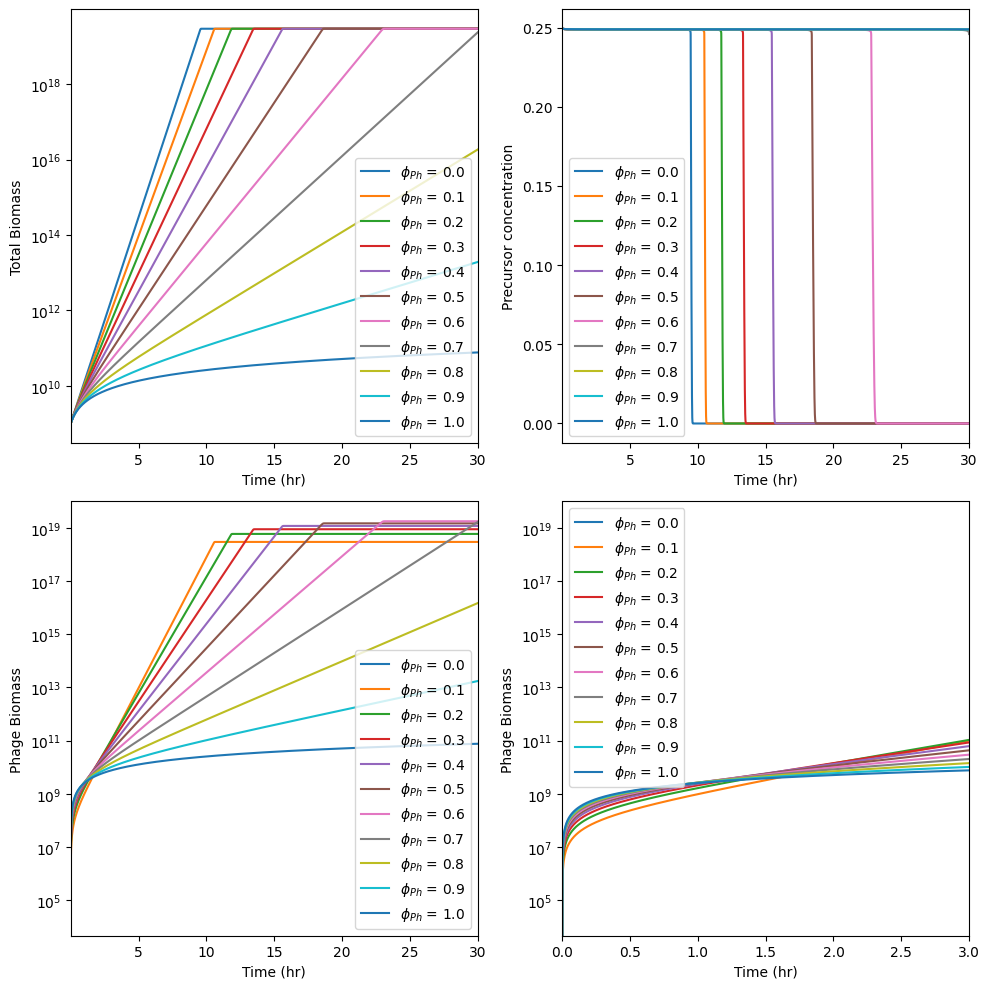

In [6]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
for i in range(len(out)):
    x_val=df.loc[df.phi_Ph_val==phi_Ph_vals[i]].t
    y_val=df.loc[df.phi_Ph_val==phi_Ph_vals[i]].M
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi_Ph_vals[i]))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Total Biomass')
plt.yscale('log')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,2)
for i in range(len(out)):
    x_val=df.loc[df.phi_Ph_val==phi_Ph_vals[i]].t
    y_val=df.loc[df.phi_Ph_val==phi_Ph_vals[i]].c_pc
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi_Ph_vals[i]))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Precursor concentration')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,3)
for i in range(len(out)):
    x_val=df.loc[df.phi_Ph_val==phi_Ph_vals[i]].t
    y_val=df.loc[df.phi_Ph_val==phi_Ph_vals[i]].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi_Ph_vals[i]))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.xlim([1e-2,3e1]);

plt.subplot(2,2,4)
for i in range(len(out)):
    x_val=df.loc[df.phi_Ph_val==phi_Ph_vals[i]].t
    y_val=df.loc[df.phi_Ph_val==phi_Ph_vals[i]].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi_Ph_vals[i]))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.xlim([0,3]);

plt.tight_layout()


In the first subplot above, we first verify the accumulation of total biomass over time for each phage proteome allocation. As expected, all $\phi_{Ph} < 1$ values yield a new steady state with gradually increasing growth rates as $\phi_{Ph}$ decreases. It is noteworthy that $\phi_{Ph} = 1$ never reaches a new steady state. For that condition, ribosomal and metabolic proteins are continually diluted by the newly translated phage proteins and asymptotically reach a state where translation is stunted.

The second subplot is a control to confirm that growth stops simultaneously with precursor concentration.

The third subplot shows the accumulation of phage biomass over time. This plot is similar qualitatively to the total biomass growth with two quantiative differences:
- The final phage biomass is different for each allocation while the final total biomass is always the same (we expect $M_{Ph\ final} \approx \phi_{Ph}*M_{tot\ final}$ )
- The initial dynamics are different: higher $\phi_{Ph}$ values accumulate phage biomass faster initially but reach a slower steady state.

The fourth subplot displays these two different dynamics for each $\phi_{Ph}$ value.

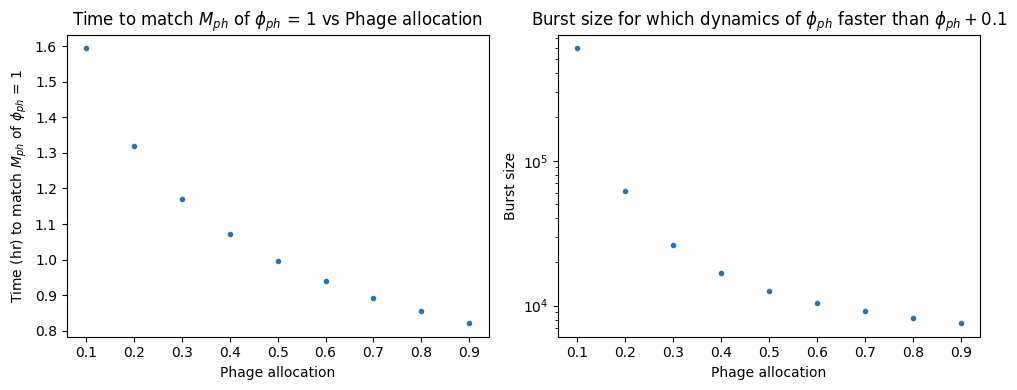

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
phi_val = []
time_match = []
for i in range(len(out)-2):
    phi_val+=[phi_Ph_vals[i+1]]
    for j in range(len(out[i+1])):
        if out[-1][j][4] < out[i+1][j][4]:
            time_match+=[time[j]]
            break

plt.plot(phi_val,time_match,'.',label='nu_max = %.1f'%(phi_Ph_vals[i]))

plt.xlabel('Phage allocation')
plt.ylabel('Time (hr) to match $M_{ph}$ of $\phi_{ph}$ = 1')
plt.title('Time to match $M_{ph}$ of $\phi_{ph}$ = 1 vs Phage allocation')

plt.subplot(1,2,2)
burst_size_match = []
phi_val = []
for i in range(len(out)-2):
    phi_val+=[phi_Ph_vals[-i-2]]
    for j in range(len(out[-i-1])):
        if out[-i-2][j][4] > out[-i-1][j][4]:
            burst_size_match +=[out[-i-2][j][4]//m_phage]
            break
plt.plot(phi_val,burst_size_match,'.')
plt.xlabel('Phage allocation')
plt.ylabel('Burst size')
plt.title('Burst size for which dynamics of $\phi_{ph}$ faster than $\phi_{ph}+0.1$')
plt.yscale('log')

plt.tight_layout()

The two subplots above display quantitative metrics of phage proteome translation dynamics to compare the different phage allocation strategies. These metrics arise from the cross-overs between phage allocation curves in fourth subplot above.

The left subplot shows the time for which a given phage allocation matches the proteinaceous mass of a complete phage allocation ($\phi_{Ph}=1$). As expected, this time is shorter for higher phage allocations. This plot showcases that high allocations are significantly different in timescales compared to lower allocations.

The right subplot indicates the "burst size" (number of phages in the cell) for which a given allocation is the fastest strategy compared to any lower allocations. As "burst size" increases, the best allocation strategy is increasingly smaller because a steady state with a faster is reached. It seems that the burst size is asymptotically approaching a threshold value as $\phi_{Ph}$ approaches 1, indicating that maximal phage allocation is the best strategy for any burst size below this value.

### Future things to do

- Plot burst size vs fastest time with color coding for each allocation
- Plot with different nutrient conditions (heatmaps)